In [76]:
"""""
 *  \brief     data_analysis.ipynb
 *  \author    Jonathan Reymond
 *  \version   1.0
 *  \date      2023-02-14
 *  \pre       None
 *  \copyright (c) 2022 CSEM
 *
 *   CSEM S.A.
 *   Jaquet-Droz 1
 *   CH-2000 Neuchâtel
 *   http://www.csem.ch
 *
 *
 *   THIS PROGRAM IS CONFIDENTIAL AND CANNOT BE DISTRIBUTED
 *   WITHOUT THE CSEM PRIOR WRITTEN AGREEMENT.
 *
 *   CSEM is the owner of this source code and is authorised to use, to modify
 *   and to keep confidential all new modifications of this code.
 *
 """

from constants import *
from prepare_data import *
from tools import *
import os
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchaudio.transforms import Resample
import functools
import operator
import math
from extract_data import *
from random import randint
import time 
from scipy.io import wavfile
from collections import Counter
from sklearn.linear_model import LinearRegression
from datetime import timedelta
os.chdir('/local/user/jrn/tinyml-challenge-2022')

In [ ]:
# def get_result_filename(hour=None, test=False, suffix=""):

#     if hour is None :
#         return OUTPUT_FOLDER + 'data' + suffix + '.pkl'
#     else :
#         return OUTPUT_FOLDER + 'data_hour_' + str(hour) + suffix + '.pkl'

## Microbit accuracy test

In [13]:
station_test = pd.read_csv('/local/user/jrn/tinyml-challenge-2022/ml_training/preprocess_data/LOG00491.TXT', header=0,names=['test'])
station_test

,test
0,5025
1,605069
2,1205113
3,1805157
4,2405201
...,...
103,61809557
104,62409601
105,63009645
106,63609689


In [16]:
def to_diff(data):
    data = list(data)
    data_new = [0]
    for i in range(1, len(data)):
        data_new.append(data[i] - data[i - 1])
    return data_new

a = to_diff(station_test['test'].to_list())

Counter(a)


Counter({0: 1, 600044: 107})

In [6]:
(108 * 10) % 60, (108 * 10) // 60

(0, 18)

## Preprocess test runtime

In [106]:
df = pd.read_pickle(get_result_filename(0))
resampler = Resample(SAMPLING_FREQUENCY, 8000, resampling_method="kaiser_window", lowpass_filter_width=8)

start_time = time.time()
df['audio_test1'] = df['audio'].map(lambda x : resampler(torch.FloatTensor(x)).numpy())
print('time 1 : ', time.time() - start_time)


merge_times = []
for i in range(10):
    start_time = time.time()
    flat_audio = np.concatenate(df['audio'].to_numpy())
    merge_times.append(time.time() - start_time)

merge_time = np.array(merge_times).mean()
print('time merge :', merge_time)

start_time = time.time()
flat_audio_resampled = resampler(torch.FloatTensor(flat_audio)).numpy()

process_time = time.time() - start_time
print('process time:', process_time)

start_time = time.time()
df['audio_test2'] = np.split(flat_audio_resampled, len(flat_audio_resampled) // 8000)
split_time = time.time() - start_time
print('split time:', split_time)

print('total 2nd process:', merge_time + process_time + split_time)




KeyboardInterrupt: 

In [102]:
use_irq = False
use_audio_stats = False

df = pd.read_pickle(get_result_filename(0))


audio_stream = np.concatenate(df['audio'].to_numpy())

start_time = time.time()
data_stats = df.drop(['timestamp', 'audio'], axis=1).agg(['min', 'max', 'mean', 'var'])

# pd.Series(audio_stream).agg(['min', 'max', 'mean', 'var'])
audio_stats = dict(min = audio_stream.min(),
                    max = audio_stream.max(),
                    mean = audio_stream.mean(),
                    var = audio_stream.var())

if use_irq:
    audio_stats.update(low_quantile = np.quantile(audio_stream,0.25), high_quantile = np.quantile(audio_stream,0.75))


print(time.time() - start_time)
audio_stats

0.08945131301879883


{'min': -0.5237732,
 'max': 0.30975342,
 'mean': -0.054842524,
 'var': 8.314524e-06}

In [110]:

def filter(Wn, btype, sampling_freq, order=5):
    if sampling_freq is None:
        sampling_freq = SAMPLING_FREQUENCY
    b, a = butter(order, Wn, fs=sampling_freq, btype=btype, analog=False)
    return lambda x : lfilter(b, a, x)


In [112]:
audio_pipeline = []
resampling_freq = 9000
highcut_freq = 4000
lowcut_freq = 2000


if resampling_freq:
    resampler = Resample(SAMPLING_FREQUENCY, resampling_freq, resampling_method="kaiser_window", lowpass_filter_width=8)
    audio_pipeline.append(lambda x : resampler(torch.FloatTensor(x)).numpy())

if lowcut_freq and highcut_freq:
    bandpass_filter = filter([lowcut_freq, highcut_freq], 'bandpass', resampling_freq)
    audio_pipeline.append(bandpass_filter)
elif lowcut_freq:
    audio_pipeline.append(filter(lowcut_freq, 'highpass', resampling_freq))
elif highcut_freq:
    audio_pipeline.append(filter(highcut_freq, 'lowpass', resampling_freq))





audio_pipeline

res_audio = audio_stream.copy()
for layer_process in audio_pipeline :
    res_audio = layer_process(res_audio)

    

    

    
    

## weather station check

In [3]:
os.path.exists(STATION_FOLDER)

True

In [4]:


def create_station_df2(with_process=True, wind_vector=False):
    '''create the weather station dataframe from the files generated by the spark openlog

    Args:
        wind_vector (bool, optional): if we want to add a vector for the wind direction. Defaults to False.

    Returns:
        dataframe: weather station dataframe preprocessed
    '''
    station_filename = STATION_FILENAMES()[0]
    correct_log_file(station_filename)
    
    station_df = pd.read_csv(station_filename, header=0, names=STATION_HEADER)
    #change from mms to sec
    station_df['timestamp'] *= 1/1000
    #add start timestamp for correct time
    station_df['timestamp'] += STATION_START_TIMESTAMP
    station_df = preprocess_weather_station(station_df, wind_vector)

    station_df= station_df[station_df['wind_count'] > 0 ]
    return station_df

<AxesSubplot:xlabel='wind_dir', ylabel='count'>

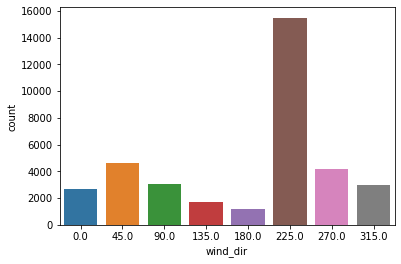

In [5]:
df = create_station_df2(True, True)
sns.countplot(x=np.round(df['wind_dir'] * RAD_ANGLE / (2 *np.pi) * 360))#.apply(lambda x : np.round(x * RAD_ANGLE /np.pi , 3)));

<AxesSubplot:ylabel='count'>

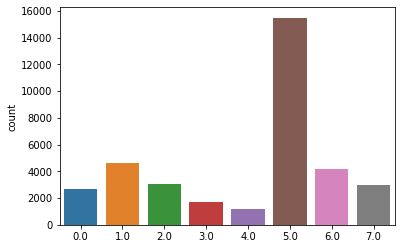

In [6]:
angles_rad = np.arctan2(df['wind_y'], df['wind_x'])
result_dir = np.round(angles_rad / RAD_ANGLE) % len(WIND_DIRECTIONS)

sns.countplot(x=result_dir)

## Audio analysis

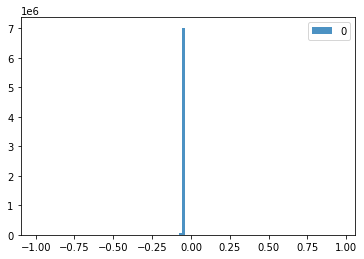

In [14]:

# Create the subplots
# fig, axes = plt.subplots(nrows=n_rows, figsize=(15, 15))

for hour, df in dfs_iterator():
    audio = df['audio'].tolist()
    
    plt.hist(np.array(list(chain.from_iterable(process_audio(audio)))), bins= 100,label=str(hour), alpha=0.8)

    plt.legend()
    if hour < 3:
        break


    

In [15]:
df_audio_list = []
for hour, df in dfs_iterator():
    if hour > 4 :
        break
    df_audio_list.append(df[['audio', 'wind_count', 'rain_count']])

df_audio = pd.concat(df_audio_list)

df_audio['audio_processed'] = process_audio(df_audio['audio'].tolist())

all_audio_processed = merge_audio(df_audio['audio_processed'])

mean_audio = np.mean(np.mean(df_audio))

/local/user/jrn/python_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/local/user/jrn/python_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [16]:
with_process = True

suff = '_processed' if with_process else ''
df_audio['audio_mean'] = df_audio['audio'+ suff].map(lambda x : np.mean(x)- mean_audio)
df_audio['audio_energy'] = df_audio['audio'+ suff].map(lambda x :  np.sum(np.abs(x - mean_audio)**2))
get_stats(df_audio.drop(['audio', 'audio_processed'], axis=1), True, ['audio_mean', 'audio_energy']);

-----------------------------------------------
test if given column follow normal distribution
-----------------------------------------------
wind_count : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
rain_count : p-value : nan not reject null hypothesis : could come from norm distribution
audio_mean : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
audio_energy : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
----------------------------------------------------
test if given column follow exponential distribution
----------------------------------------------------
wind_count : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from exp distribution
rain_count : p-value : nan not reject null hypothesis : could come from exp distribution
audio_mean : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from exp d

/local/user/jrn/python_env/lib/python3.9/site-packages/statsmodels/stats/_lilliefors.py:279: RuntimeWarning: invalid value encountered in divide
  z = (x - x.mean()) / x.std(ddof=1)
/local/user/jrn/python_env/lib/python3.9/site-packages/statsmodels/stats/_lilliefors.py:283: RuntimeWarning: invalid value encountered in divide
  z = x / x.mean()
/local/user/jrn/python_env/lib/python3.9/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


## Other parameters analysis

In [ ]:
df_w = get_dataframe_without_audio()
get_stats(df_w, True)

-----------------------------------------------
test if given column follow normal distribution
-----------------------------------------------
humidity : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
pressure : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
temperature : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
wind_dir : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
wind_count : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
rain_count : p-value : nan not reject null hypothesis : could come from norm distribution
wind_x : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
wind_y : p-value : 0.0009999999999998899 reject null hypothesis : doesn't come from norm distribution
-------------------------------------

/local/user/jrn/python_env/lib/python3.9/site-packages/statsmodels/stats/_lilliefors.py:279: RuntimeWarning: invalid value encountered in divide
  z = (x - x.mean()) / x.std(ddof=1)
/local/user/jrn/python_env/lib/python3.9/site-packages/statsmodels/stats/_lilliefors.py:283: RuntimeWarning: invalid value encountered in divide
  z = x / x.mean()
/local/user/jrn/python_env/lib/python3.9/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,humidity,pressure,temperature,wind_dir,wind_count,rain_count,wind_x,wind_y
min,55.374301,96934.635239,13.746140,0.000000,0.000000,0.0,-8.485281,-12.000000
max,85.926471,97160.514035,21.299675,7.000000,12.000000,0.0,8.000000,5.656854
mean,76.908081,97040.041457,16.097191,4.565348,3.301671,0.0,-0.701326,-2.223545
var,55.856546,4216.427212,2.735186,4.858794,9.586352,0.0,7.642042,7.409990


/local/user/jrn/python_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/local/user/jrn/python_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/local/user/jrn/python_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

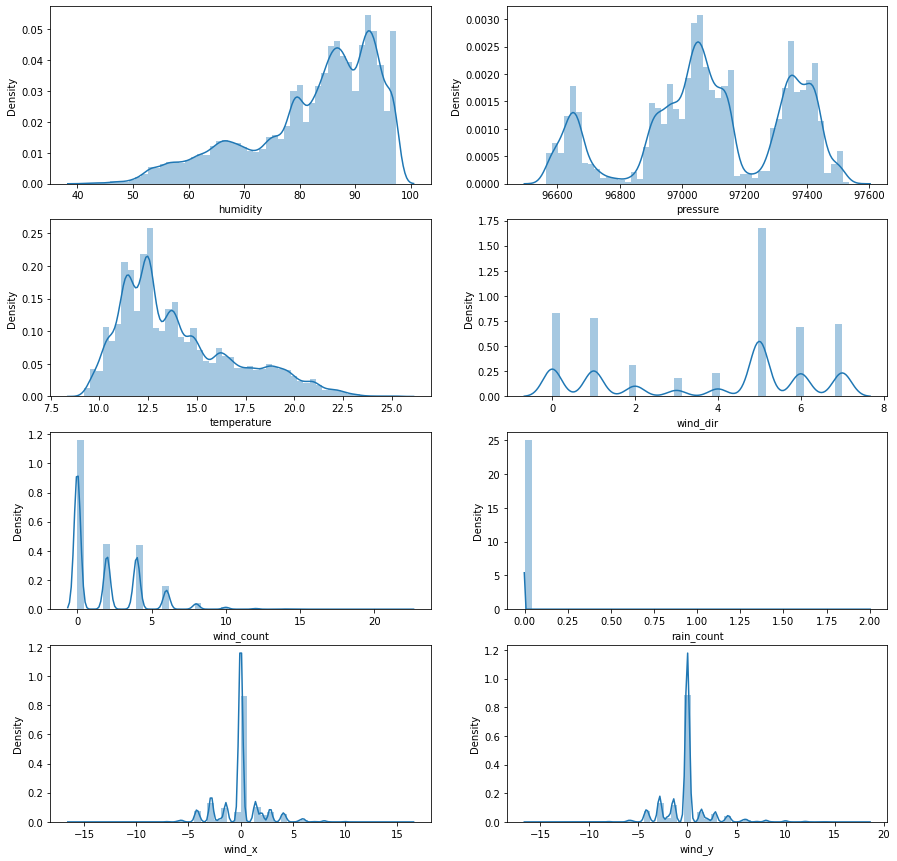

In [9]:
df = get_dataframe_without_audio()

n_cols= 2
n_rows= math.ceil(len(list(df.columns)) / n_cols)
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

for i, column in enumerate(df.columns):
    sns.distplot(df[column],ax=axes[i//n_cols,i%n_cols])

In [5]:
df['pressure'][df['pressure'] < 95000]

0    70963.655389
Name: pressure, dtype: float64

In [8]:
df['pressure'].iloc[0: 10]

0    70963.655389
1    97524.378839
2    97513.332279
3    97513.028618
4    97518.039527
5    97515.528791
6    97525.059253
7    97523.961125
8    97525.550752
9    97520.539693
Name: pressure, dtype: float64

## Compressing label test

In [19]:
df['wind_count'].value_counts().sort_index()

0.0     76836
1.0        23
2.0     29626
3.0        20
4.0     29173
5.0        24
6.0     10574
7.0         8
8.0      2972
9.0         3
10.0     1031
11.0        2
12.0      358
13.0        1
14.0      113
16.0       19
18.0        4
20.0        4
22.0        2
Name: wind_count, dtype: int64

In [ ]:
def compress_labels(x):
    if 0 <= x and x <= 6.5:
        return 0

    elif 6.5 < x and x <= 16 :
        return 6
    else :
        raise Exception("Value not in the range [0, 16]") 

df['wind_count'].map(compress_labels).value_counts().sort_index()

0    65279
6    11693
Name: wind_count, dtype: int64

## Wind distribution test

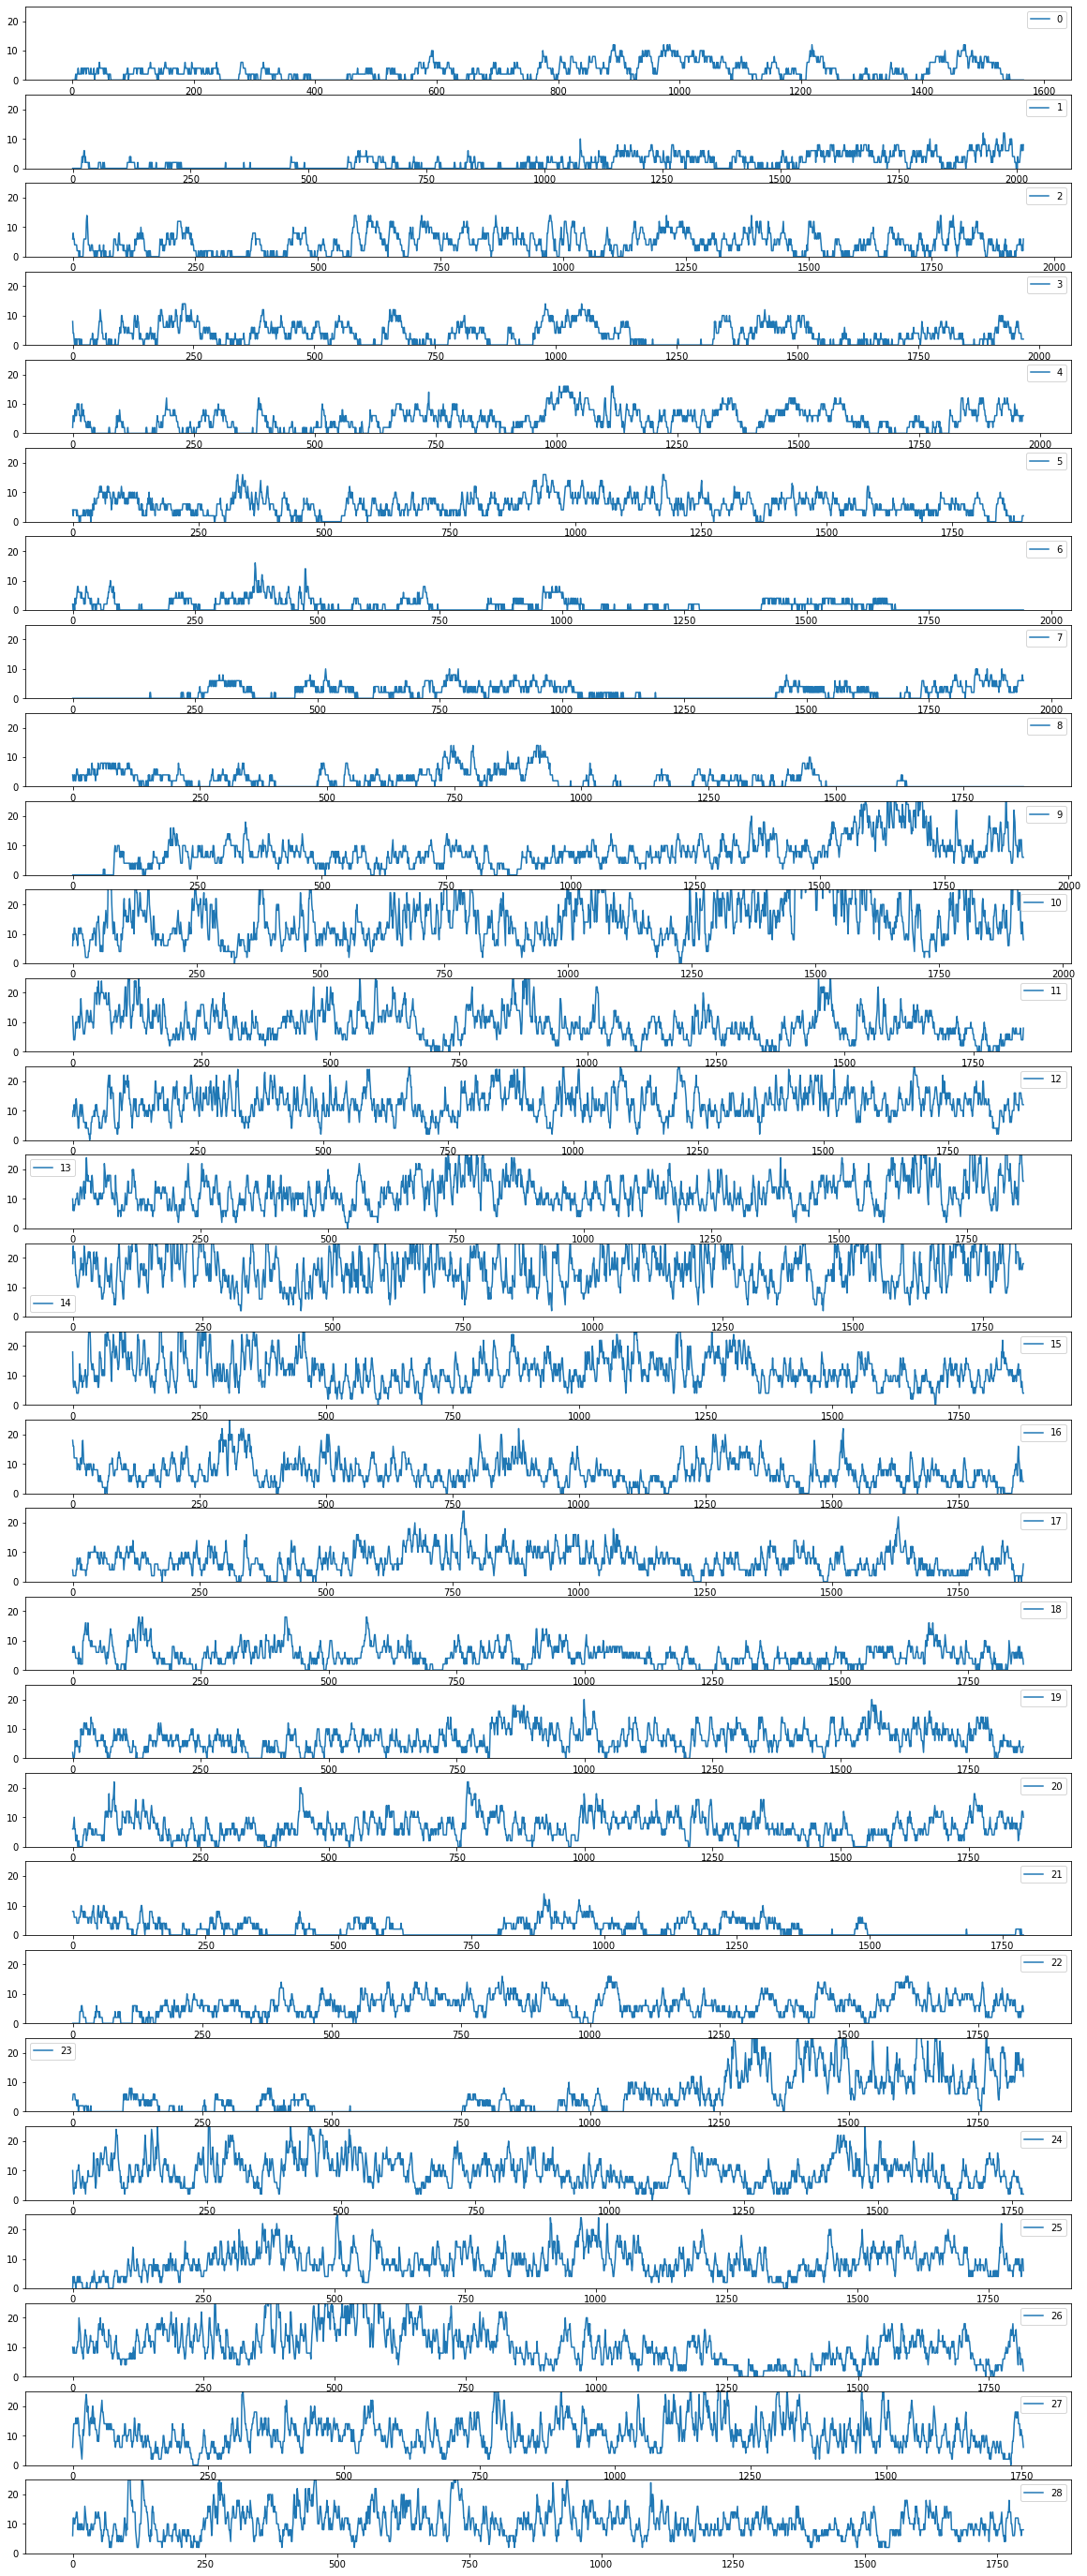

In [8]:
num_hours = 29
fig, axes = plt.subplots(nrows=num_hours, ncols=1, figsize=(20, 50))

for hour in range(num_hours):
        merged_df = pd.read_pickle(get_result_filename(hour))
        axes[hour].plot(merged_df['wind_count'], label=str(hour))
        # axes[hour].ylim([10, 23])
        axes[hour].axis(ymin=0, ymax=25)
        axes[hour].legend()

plt.savefig(fname='dataframe_test')


In [10]:
def get_linear_value(x, point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    slope = (y2 - y1)/(x2 - x1)
    intercept = - slope * x1 + y1
    return slope * x + intercept

get_linear_value(1, (3, 2), (9, 4))

1.3333333333333333

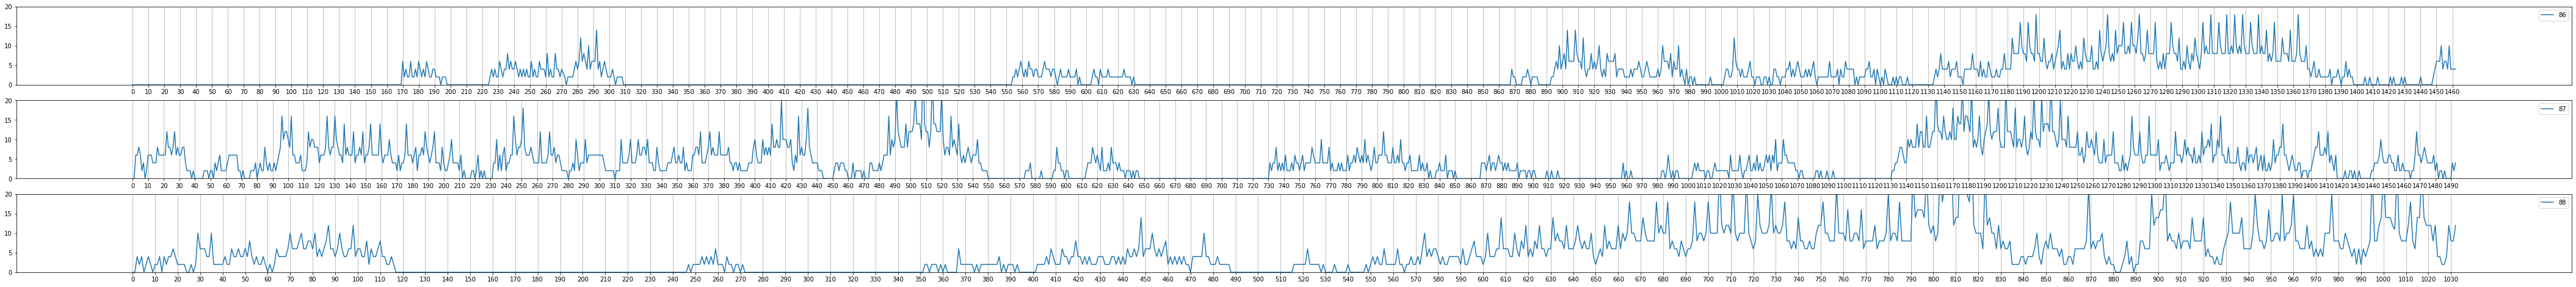

In [110]:
# Analysis only over 2/3 last hours

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(75, 8))

idx = 0
for hour in range(86,MIC_NUM_HOURS):
        merged_df = pd.read_pickle(get_result_filename(hour))
        axes[idx].plot(merged_df['wind_count'], label=str(hour))
        # axes[hour].ylim([10, 23])
        axes[idx].axis(ymin=0, ymax=20)
        axes[idx].set_xticks(np.arange(0, len(merged_df), 10.0))
        axes[idx].grid(axis='x')
        axes[idx].legend()
        idx += 1

plt.savefig(fname='dataframe_test')

In [92]:
318681.801 - 318315.921

365.88000000000466

In [98]:
print(911 - 759)
print(779 - 626)

152
153


In [15]:
911 - 779

132

In [95]:
# true
merged_df[['timestamp','rain_count']].iloc[911]

timestamp     319000.657
rain_count         0.000
Name: 911, dtype: float64

In [99]:
STATION_START_TIMESTAMP

127.0

In [96]:
# false
merged_df[['timestamp','rain_count']].iloc[779]

timestamp     318681.801
rain_count         2.000
Name: 779, dtype: float64

In [90]:

h = 88
df_hour = pd.read_pickle(get_result_filename(h))
start_index = 750
end_index = 920
audio_data = np.float32(np.concatenate(df_hour['audio'].iloc[start_index: end_index].to_list()))

wave_filename = str(h) + '_' + str(start_index) + '-' + str(end_index) + '.wav'
print('cropped', wave_filename)

sf.write(WAVE_FOLDER + '/test/'+ wave_filename, audio_data, SAMPLING_FREQUENCY)



cropped 88_750-920.wav


## Rain test

In [ ]:
# for hour in range(MIC_NUM_HOURS):
#         merged_df = pd.read_pickle(get_result_filename(hour))
#         print(hour, merged_df['rain_count']

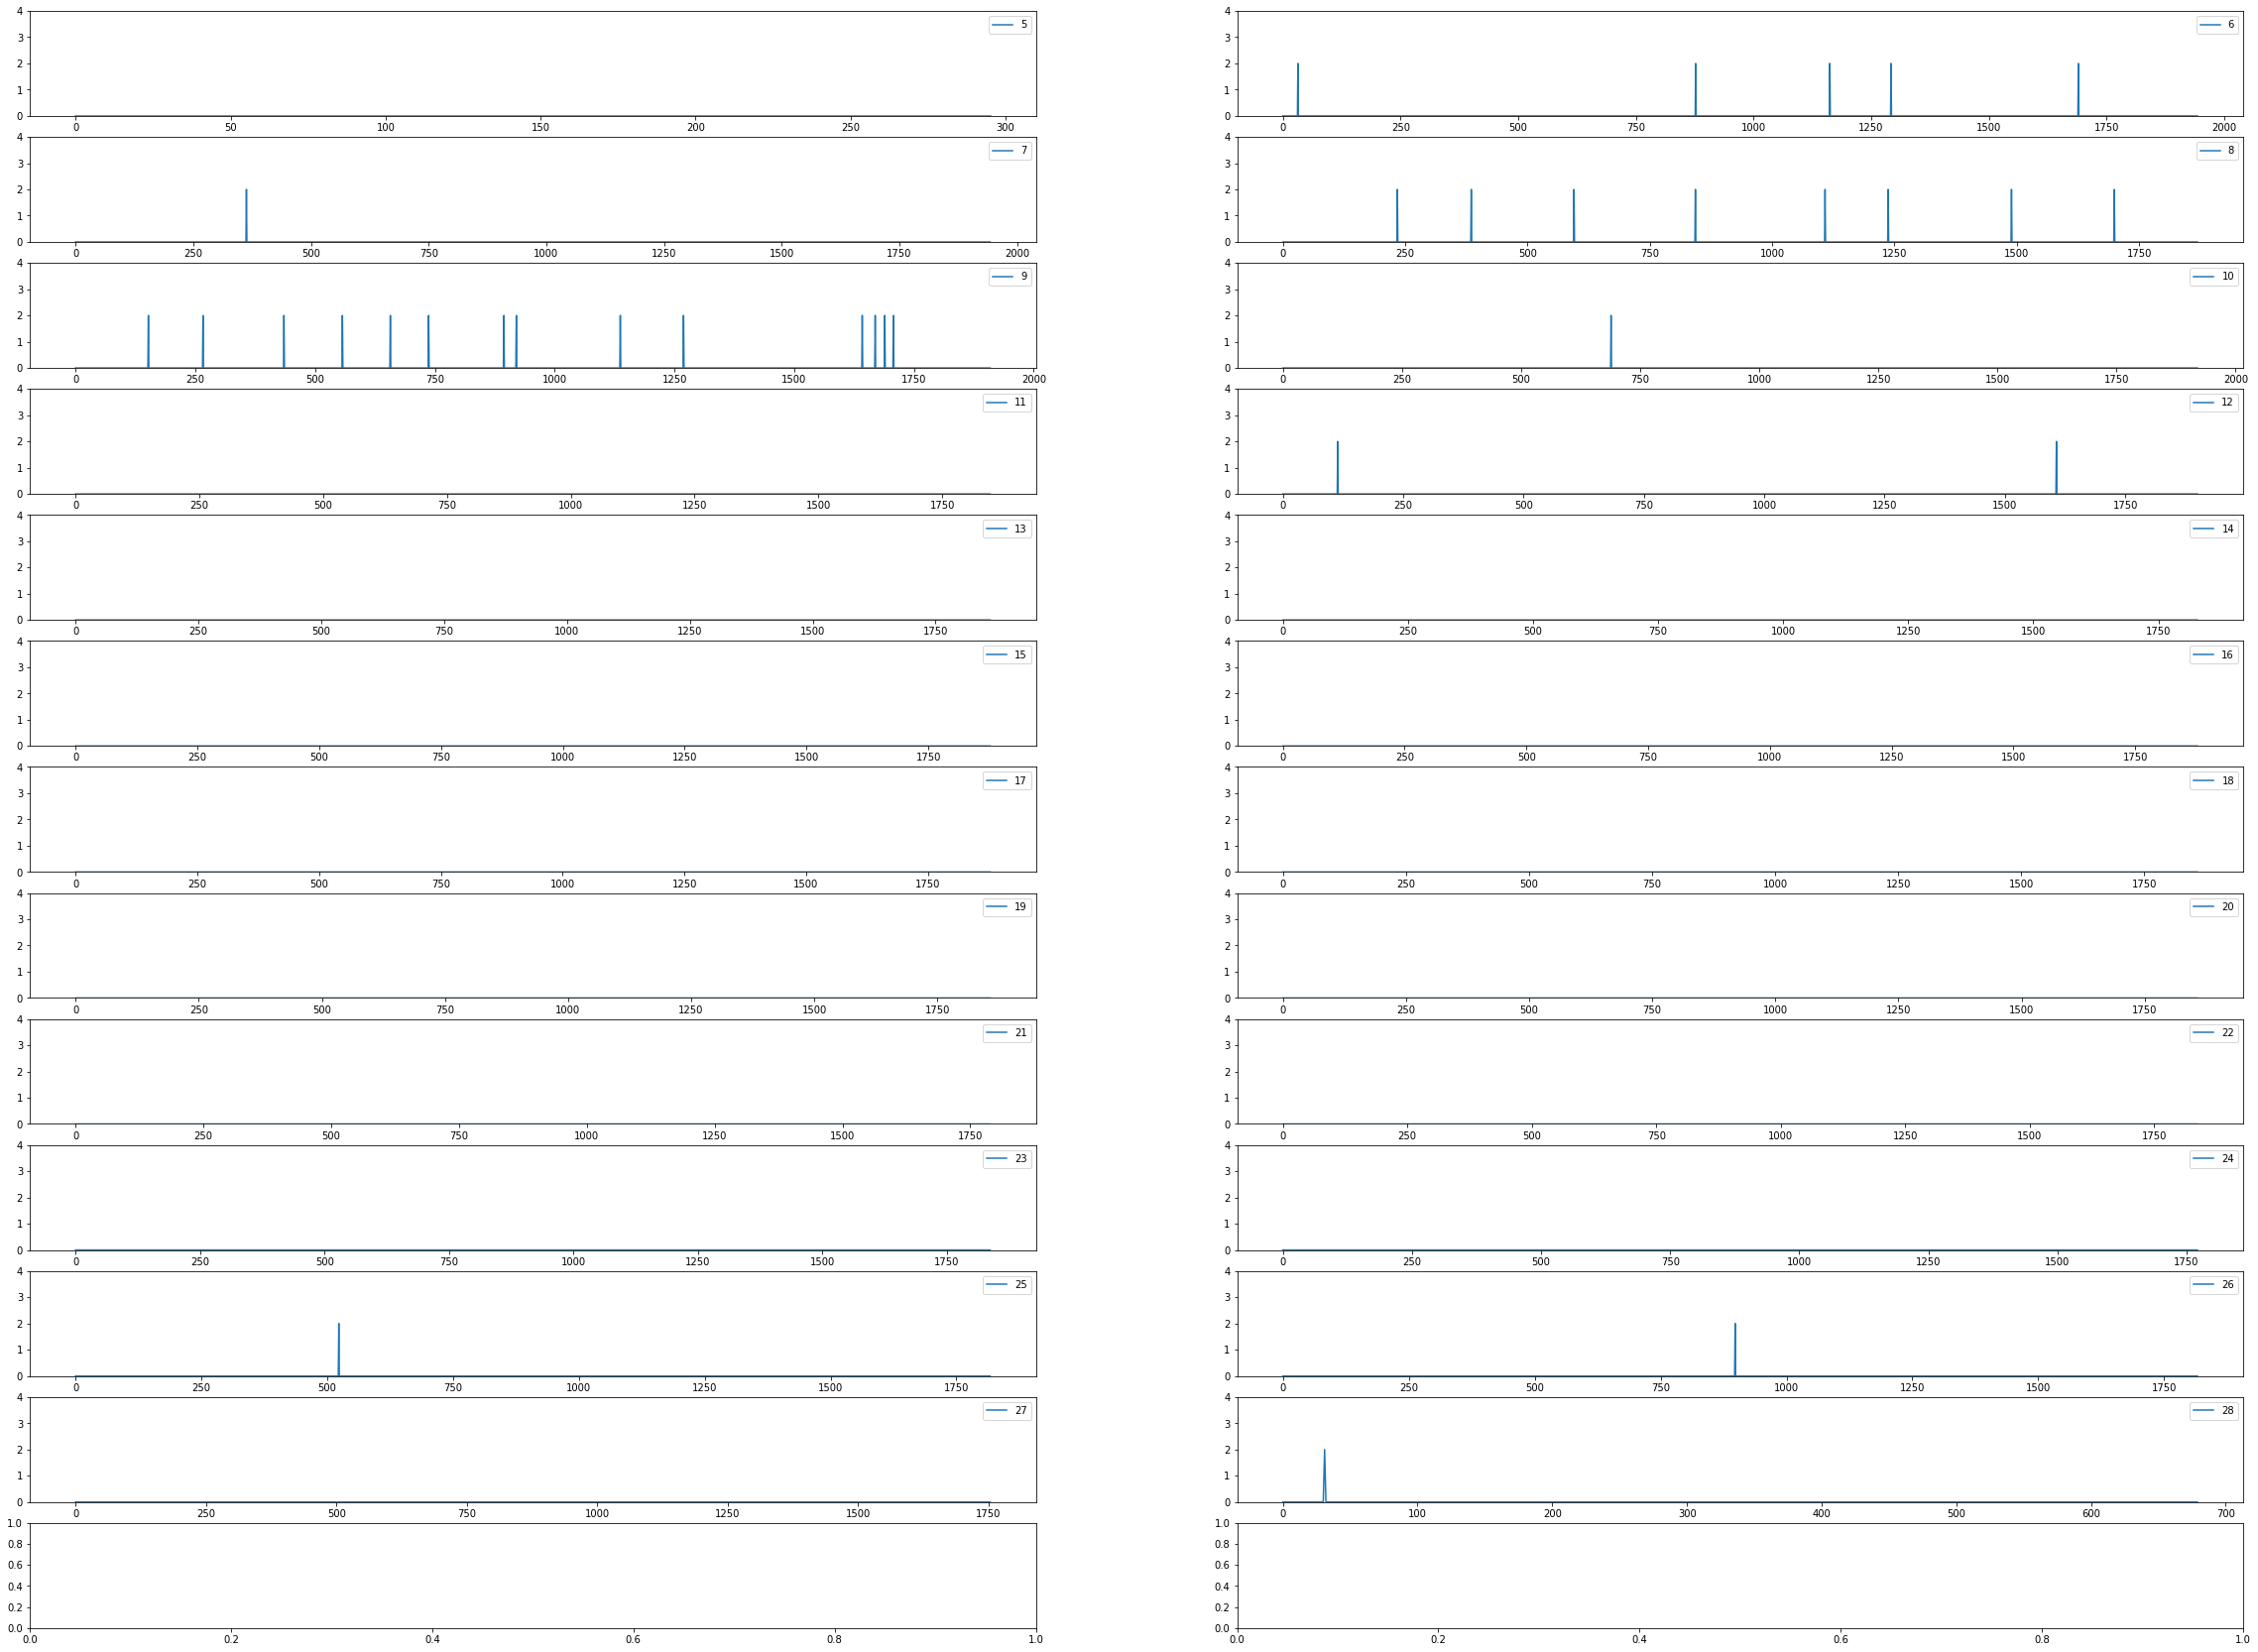

In [3]:
studied_hours = INDEX_HOURS

nrows = int(len(studied_hours) /2) + 1
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 30))

idx = 0
for hour in studied_hours:
        merged_df = pd.read_pickle(get_result_filename(hour))
        ax = axes[idx // ncols ,idx % ncols]
        ax.plot(merged_df['rain_count'] , label=str(hour))
        # axes[hour].ylim([10, 23])
        ax.axis(ymin=0, ymax=4)
        ax.legend()
        idx += 1

plt.savefig(fname='dataframe_test2')

In [9]:
for hour in studied_hours:
    rain_df = pd.read_pickle(get_result_filename(hour))
    
    timestamps = rain_df[rain_df['rain_count'] > 0]['timestamp']
    index_time = np.dstack((timestamps.index.values // 60, timestamps.index.values % 60))
    if len(timestamps) > 0 :
        print('hour:', hour)
        # for idx, t in enumerate(timestamps):
        #     print(idx +1, t)
        r = [index_to_time_entry(t) for t in timestamps.index.values]
        print(r)


hour: 87
[(17, 50), (17, 51), (17, 52), (17, 53), (17, 54), (17, 55), (17, 56), (17, 57), (17, 58), (17, 59), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (18, 32), (18, 33), (18, 34), (18, 35), (18, 36), (18, 37), (18, 38), (18, 39), (18, 40), (18, 41), (18, 42), (18, 43), (18, 44), (18, 45), (18, 46), (18, 47), (18, 48), (18, 49), (18, 50), (18, 51), (18, 52), (18, 53), (18, 54), (18, 55), (18, 56), (18, 57), (18, 58), (18, 59), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), 

In [8]:
index_to_time_entry(1239)

(20, 39)

## Test length recording

In [10]:
audio, dfsa = extract_sensors_files(MIC_NUM_HOURS-2)
len(dfsa)

1335

In [24]:
slope = 0.9967787669329223
# slope = 1

In [5]:
audio, sensor_df = extract_sensors_files(MIC_NUM_HOURS-1)
last_max_timestamp = sensor_df['timestamp'].iloc[-1]
print(last_max_timestamp)

station_filename = STATION_FILENAMES()[0]
station_df = pd.read_csv(station_filename, header=0, names=STATION_HEADER)
last_station_timestamp = station_df['timestamp'].iloc[-1] * 1/slope
print(last_station_timestamp)


diff_start = STATION_START_TIMESTAMP * 1/slope  - MIC_START_TIMESTAMP
print(diff_start)
diff = last_max_timestamp - last_station_timestamp
diff_sec = diff / 1000 + diff_start
print(int(diff_sec // 60),'minutes', int(diff_sec % 60)) 

444408132
442974225.0
-261.0
19 minutes 32


In [26]:
time_station =  int((last_station_timestamp *  - STATION_START_TIMESTAMP) / 1000)
time_max = int((last_max_timestamp - MIC_START_TIMESTAMP)/ 1000)
get_time_hh_mm_ss(time_station)
get_time_hh_mm_ss(time_max)
get_time_hh_mm_ss(time_max - time_station)


Time in hh:mm:ss: 5 days, 3 Hours 02 Minutes 54 Seconds
Time in hh:mm:ss: 5 days, 3 Hours 26 Minutes 47 Seconds
Time in hh:mm:ss: 0 Hours 23 Minutes 53 Seconds


In [130]:
MIC_NUM_HOURS

74

In [29]:
print(get_date_after(MIC_START_DATE, last_max_timestamp))
print(get_date_after(STATION_START_DATE, int(last_station_timestamp * 1/slope)))


2022-11-08T13:54:38.132
None
2022-11-08T13:50:14.759
None


## Wav converter for test purposes

In [6]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff_freq, order=5):
    return butter(order, cutoff_freq, fs=SAMPLING_FREQUENCY, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, order=order)
    y = lfilter(b, a, data)
    return y


# Get the filter coefficients so we can check its frequency response.


def process_audio_to_stream(audio, lowpass_freq=None):
    audio_stream = np.array(list(chain.from_iterable(audio)))
    # sanity check
    a = np.apply_along_axis(lambda x : len(x), 1, audio)
    assert len(a[a != SAMPLING_FREQUENCY]) == 0, "Exists samples with length different from sampling frequency"

    if lowpass_freq is not None:
        audio_stream = butter_lowpass_filter(audio_stream, cutoff_freq=lowpass_freq, order=6)
    return np.float32(audio_stream)


def crop_audio(data, start, end):
    # one record per sampling freq => need to remove SAMPLING_FREQ* 1 for one second
    start_index = 0
    if start is not None:
        min_start, sec_start = start
        start_index = (min_start * 60 + sec_start) * SAMPLING_FREQUENCY
        print('start index:', start_index)
        
    end_index = len(data)
    if end is not None:
        min_end, sec_end = end
        end_index = (min_end * 60 + sec_end) * SAMPLING_FREQUENCY
        print('end index:', end_index)
    
    return data[start_index : end_index]

In [47]:

hour = 5
data = pd.read_pickle(get_result_filename(hour))['audio'].tolist()
data = process_audio_to_stream(data, 3000)

if not os.path.exists(WAVE_FOLDER + '/test/'):
    os.makedirs(WAVE_FOLDER + '/test/')

wave_filename = str(randint(0, 500)) + '_' +  get_filename(hour, '.wav')


minutes = 26
seconds = 36
data_cropped = crop_audio(data, [minutes, seconds], [minutes, seconds + 1])
len(data_cropped) / SAMPLING_FREQUENCY

wave_filename = str(randint(0, 500)) + get_filename(hour, '.wav')
print('cropped', wave_filename)
sf.write(WAVE_FOLDER + '/test/'+ wave_filename, data_cropped, SAMPLING_FREQUENCY)


start index: 26148864
end index: 26165248
cropped 23232856_hour_5.wav


In [29]:
hours = [5, 6, 6, 7, 8, 8, 9, 10, 12, 25, 26, 28, 28, 43]

indexes = [1596, 1293, 1691, 364, 235, 844, 153, 690, 1608, 524, 899, 32, 682, 1300]

for i in range(len(hours)):
    audio, sensor_df = extract_sensors_files(hours[i])
    print(int(sensor_df.iloc[indexes[i]]['timestamp']))
    
for j in range(30):
    print('no')
    

21037302
23996524
24730696
25883836
29261882
30429332
32696850
37300538
46246287
91046739
95386299
100875372
102169941
157638070
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no


In [24]:
audio, sensor_df = extract_sensors_files(5)

In [26]:
sensor_df.iloc[1596]['timestamp']

21037302.0

In [21]:
for hour, inter in interrupts:
    df = pd.read_pickle(get_result_filename(hour))
    # print('hour', hour)
    timestamp_max = df.iloc[inter]['timestamp']
    print(timestamp_max)

for i in range(30):
    print(i)


IndexError: single positional indexer is out-of-bounds

In [90]:
# slope normal
slope_9 = 0.995753028060009 
slope_9_drop = 0.9960238682681485
slope_11 = 0.9967787669329223

# slope abs error
abs_slope_9 = 0.004246971939990812
abs_slope_9_drop = 0.003976131731851505
abs_slope_11 = 0.0032212330670777756


Coefficient of determination R^2 0.9813144916887773
Slope: 0.9930455626510167
Intercept: -35.29004593307991


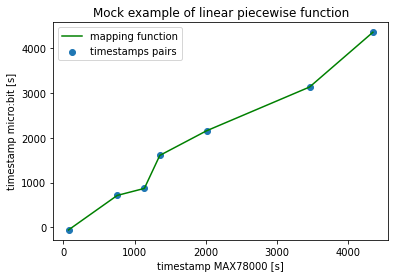

In [74]:
abs_diff = True
drop_last = True
date = '11' #'11'

timestamp_comp = pd.read_csv('/local/user/jrn/tinyml-challenge-2022/data/outside/' + date + '_11_2022/other/timestamp_comparison.csv',
                             header=0)

if drop_last:
    timestamp_comp = timestamp_comp[11:-9]

fig, ax = plt.subplots()

ax.set_xlabel("timestamp MAX78000 [s]")
ax.set_ylabel("timestamp micro:bit [s]")

linear_regressor = LinearRegression()
X = timestamp_comp['timestamp max'].to_numpy().reshape(-1, 1) - 90000
Y = timestamp_comp['timestamp microbit'].to_numpy().reshape(-1, 1) - 90000
plt.title("Mock example of linear piecewise function")

if abs_diff :
    Y = np.abs(X -Y) * 300 - 79000
    # ax.set_ylabel("Abs difference [s]")
    # plt.title("Absolute difference regression prediction and actual timestamp")


linear_regressor.fit(X, Y)

Y_pred = linear_regressor.predict(X)

# linear_regressor.coef_[0][0] = slope_9_drop
# Y_pred = linear_regressor.predict(X)

# ax.plot(X, Y_pred, color='blue', label='linear regression')

ax.plot(X, Y, color='g', label='mapping function')
ax.scatter(x=X, y=Y, label='timestamps pairs')


plt.legend()
print('Coefficient of determination R^2', linear_regressor.score(X, Y))
print("Slope:", linear_regressor.coef_[0][0])
print("Intercept:", linear_regressor.intercept_[0])

plt.savefig('mock_example',dpi=200)

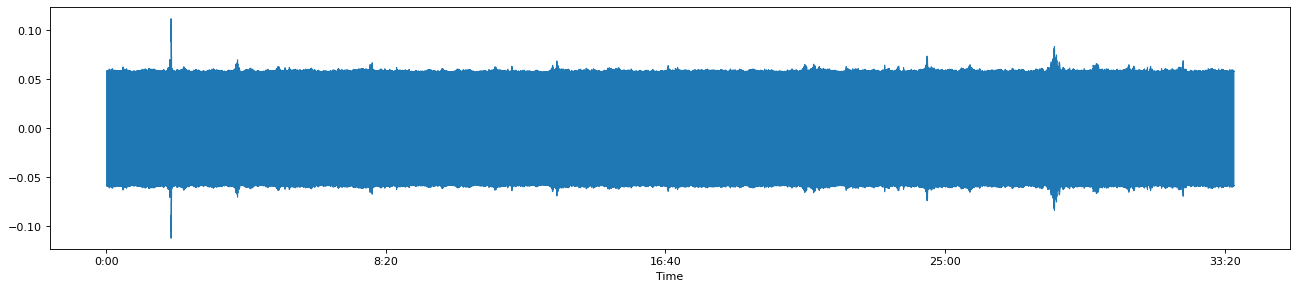

In [ ]:
# sr, data = wavfile.read(WAVE_FOLDER + get_filename(hour, '.wav'))
plt.figure(figsize=(20, 4), dpi=80)

data, sr = librosa.load(WAVE_FOLDER + get_filename(hour, '.wav'), sr=None)
librosa.display.waveshow(data, sr=sr)

In [ ]:
data, sr

(array([-0.05322266, -0.05334473, -0.05349731, ..., -0.05490112,
        -0.05477905, -0.0546875 ], dtype=float32),
 16384)

In [ ]:
data.dtype
wave_filename = str(randint(0, 500)) + get_filename(hour, '.wav') 
print(wave_filename)


48327024_hour_1.wav


In [49]:
# 87
drop_87 = [[( 17,50), (18,00)], 
                [(18,44), (20,30)],
                [(20, 40), (-1, -1)]]

rain_87 = [[(18,00), (18,44)]]

# 88
drop_88 = [[(0,0), (0,24)],
                [(2,40), (3,53)],
                [(4, 13), (4, 37)],
                [(6, 00), (10, 20)],
                [(11, 45), (12, 17)],
                [(12, 30), (13, 20)],
                [(13, 50), (14, 57)], 
                [(15, 4), (-1, -1)]]

rain_88 = [[(0,24), (2, 40)],
                [(3,53), (4,13)],
                [(4, 37), (6, 00)],
                [(10, 20), (11, 45)],
                [(12, 17), (12, 30)],
                [(13, 20), (13, 50)],
                [(14, 57), (15, 4)]] 


def get_interval_rain(l):
    l_index_res = []
    for interval in l :
        left_idx = time_to_index2(*interval[0])
        right_idx = time_to_index2(*interval[1])
        l_index_res.append((left_idx, right_idx))
    return l_index_res

def set_rain_level_to_df(df, index_intervals, rain_level):
    for interval in index_intervals :
        df['rain_count'].iloc[interval[0]: interval[1]] = rain_level
    print(df['rain_count'].value_counts())
    return df




In [50]:
# 87 process
df_87 = pd.read_pickle(get_result_filename(87))
df_87 = set_rain_level_to_df(df_87, get_interval_rain(drop_87), 1)
df_87 = set_rain_level_to_df(df_87, get_interval_rain(rain_87), 2)



# 88 process
df_88 = pd.read_pickle(get_result_filename(88))
df_88 = set_rain_level_to_df(df_88, get_interval_rain(drop_88), 1)
df_88 = set_rain_level_to_df(df_88, get_interval_rain(rain_88), 2)


0.0    1125
1.0     369
Name: rain_count, dtype: int64
0.0    1081
1.0     369
2.0      44
Name: rain_count, dtype: int64
1.0    658
0.0    375
Name: rain_count, dtype: int64
1.0    658
2.0    374
0.0      1
Name: rain_count, dtype: int64


/tmp/ipykernel_10537/91365948.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rain_count'].iloc[interval[0]: interval[1]] = rain_level
/tmp/ipykernel_10537/91365948.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rain_count'].iloc[interval[0]: interval[1]] = rain_level
/tmp/ipykernel_10537/91365948.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rain_count'].iloc[interval[0]: interval[1]] = rain_level
/tmp/ip

In [51]:
df_87.to_pickle(get_result_filename(87))
df_88.to_pickle(get_result_filename(88))

In [77]:
df_87_res = pd.read_pickle(get_result_filename(87))
df_88_res = pd.read_pickle(get_result_filename(88))


nrows = int(MIC_NUM_HOURS /2) + 1
ncols = 2

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(40, 8))
ax[0].plot(df_87_res['rain_count'], label=87)
ax[0].axis(ymin=0, ymax=3)
ax[0].legend()
ax[1].plot(df_88_res['rain_count'], label=88)
ax[1].axis(ymin=0, ymax=3)
ax[1].legend()


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/data_9_11_2022/cropped/data_hour_87.pkl'

## Audio mfcc

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    specgram = torch.FloatTensor(specgram)
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
def to_mfcc(df):
    n_fft = 2048 * 2
    win_length = None
    hop_length = 256
    n_mels = 220
    n_mfcc = 220

    mfcc_transform = MFCC(
        sample_rate = SAMPLING_FREQUENCY,
        n_mfcc = n_mfcc,
        melkwargs = {
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
        },)
    df['audio'] = df['audio'].map(lambda x : mfcc_transform(torch.FloatTensor(x)).numpy())
    return df

In [ ]:
df_w = get_dataframe_without_audio()

stats_results = get_stats(df_w, need_print=False)

for hour, df in dfs_iterator():
    print(hour)
    df = process_data(stats_results, None, df)
    df = merge_samples(df, 2)
    df = resample(df, 16000)
    df = to_mfcc(df)
    print(df['audio'][0].shape)
    plot_spectrogram(df['audio'][0])
    break

0


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

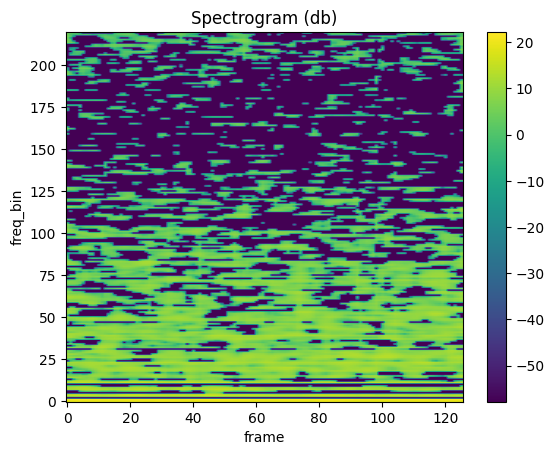

In [ ]:
plot_spectrogram(df['audio'][300])

## Draft

In [8]:
def correct_log_file(station_filename):
    '''correct the log file generated by the spark openlog : if multiple times or no header

    Args:
        station_filename (str): filename of log generated by the spark openlog, of the form '<folder path>/LOGXXXX.TXT'
    '''
    header = 'wind_dir,wind_count,rain_count'
    station_filename_temp = station_filename.replace(".TXT", '_temp.TXT')

    with open(station_filename) as fin, open(station_filename_temp, "w+") as fout:
        for line in fin:
            if line is not header:
                fout.write(line)

    os.remove(station_filename)
    os.rename(station_filename_temp, station_filename)


def make_diff(array, index, treshold=True):
    '''auxiliary function to modify the count to get the count in each time slot and not the overall count

    Args:
        array (list[int]): list of overall counts
        index (int): index of interest
        treshold (bool, optional): _description_. Defaults to True.

    Returns:
        int: the count for the time slot defined by the index
    '''
    diff = array[index] - array[index - 1]
    #dued to threshold
    if diff < 0 :
        diff = THRESHOLD - diff
    return diff



def preprocess_weather_station(station_df, wind_vector):
    '''preprocess weather station data

    Args:
        station_df (dataframe): the raw station dataframe generated in create_station_df
        wind_vector (bool): if we want to add a vector for the wind direction

    Returns:
        dataframe: processed station dataframe
    '''

    # instead of counting the overall count : just count in the time slot, assume wind and rain not counted twice
    # do rain after to track every exception since more rare than wind interrupt + rain duration longer
    wind = station_df['wind_count'].to_list()
    wind_new = [0]
    for i in range(1, len(station_df)):
        wind_new.append(make_diff(wind, i))
 
    station_df['wind_count'] = wind_new.copy()

    #replace '???' values by previous valid direction encountered
    previous_dir = station_df['wind_dir'][station_df['wind_dir'] != '???'][0]
    wind_dir_new = []
    for wind_dir in station_df['wind_dir']:
        if wind_dir != '???':
            previous_dir = wind_dir
        wind_dir_new.append(previous_dir)
    station_df['wind_dir'] = wind_dir_new

    # transform direction to int
    station_df['wind_dir'] = station_df['wind_dir'].map(WIND_DIRECTIONS)
    if wind_vector:
        #create a vector of the wind with magnitude = wind_count
        station_df["wind_x"] = station_df["wind_count"] * np.cos(station_df["wind_dir"] * RAD_ANGLE)
        station_df["wind_y"] = station_df["wind_count"] * np.sin(station_df["wind_dir"] * RAD_ANGLE)
    
    return station_df


def get_linear_value(x, point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    slope = (y2 - y1)/(x2 - x1)
    intercept = - slope * x1 + y1
    return slope * x + intercept


def correct_timestamp(station_df):
    # assume already sorted + in seconds
    time_pairs = pd.read_csv(TIMESTAMP_COMPARISON_FILE, header=0)
    time_pairs = time_pairs[["timestamp microbit","timestamp max"]]
    new_timestamps = []
    comp_idx = 0
    df_idx = 0
    print('size before:', len(station_df))
    # drop entries for which have not 2 points
    station_df = station_df[(time_pairs['timestamp microbit'].iloc[0] <= station_df['timestamp']) &
                             (station_df['timestamp'] < time_pairs['timestamp microbit'].iloc[-1])]
    print('size after:', len(station_df))
        
    for df_idx in range(len(station_df)):
        station_entry = station_df['timestamp'].iloc[df_idx]
        while time_pairs['timestamp microbit'].iloc[comp_idx] <= station_entry:
            comp_idx += 1
        if comp_idx > 0:
            output_val = get_linear_value(station_entry, tuple(time_pairs.iloc[comp_idx-1]), tuple(time_pairs.iloc[comp_idx]))
            new_timestamps.append(output_val)
        else :
            print('this should never happen')
            
    res_df = station_df.copy()
    res_df['new_timestamp'] = new_timestamps
    return res_df
    

def create_station_df(wind_vector=False):
    '''create the weather station dataframe from the files generated by the spark openlog

    Args:
        wind_vector (bool, optional): if we want to add a vector for the wind direction. Defaults to False.

    Returns:
        dataframe: weather station dataframe preprocessed
    '''
    station_filename = STATION_FILENAMES()[0]
    correct_log_file(station_filename)
    station_df = pd.read_csv(station_filename, header=0, names=STATION_HEADER)
    station_df.sort_values('timestamp', inplace=True)

    #change from mms to sec
    # station_df['timestamp'] *= (1/1000)
    #add start timestamp for correct time
    # station_df['timestamp'] += STATION_START_TIMESTAMP
    station_df = preprocess_weather_station(station_df, wind_vector)
    station_df = correct_timestamp(station_df)
    return station_df.sort_values('timestamp')

In [30]:
df_test = create_station_df()

size before: 216706
size after: 66535


In [10]:
df_test

,timestamp,wind_dir,wind_count,rain_count,new_timestamp
10384,21258873,2,2,4,2.129830e+07
10385,21260917,2,2,4,2.130035e+07
10386,21262961,2,2,4,2.130240e+07
10387,21265005,2,4,4,2.130445e+07
10388,21267049,2,4,4,2.130650e+07
...,...,...,...,...,...
76914,157247185,5,6,74,1.578888e+08
76915,157249229,5,10,74,1.578909e+08
76916,157251273,5,8,74,1.578929e+08
76917,157253317,5,10,74,1.578950e+08


NameError: name 'df_test' is not defined

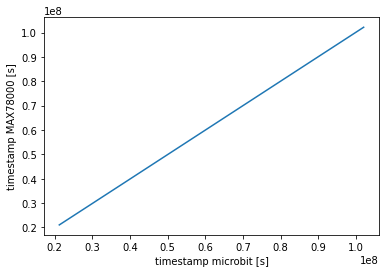

In [13]:
abs_diff = False
drop_last = True

timestamp_comp = pd.read_csv('/local/user/jrn/tinyml-challenge-2022/data/outside/9_11_2022/other/timestamp_comparison.csv',
                             header=0)

if drop_last:
    timestamp_comp = timestamp_comp[:-1]

fig, ax = plt.subplots()

ax.set_xlabel("timestamp microbit [s]")
ax.set_ylabel("timestamp MAX78000 [s]")

linear_regressor = LinearRegression()

X = timestamp_comp['timestamp microbit'].to_numpy().reshape(-1, 1)
Y = timestamp_comp['timestamp max'].to_numpy().reshape(-1, 1)
if abs_diff :
    Y = np.abs(X -Y)
    ax.set_ylabel("Abs difference [s]")


linear_regressor.fit(X, Y)

Y_pred = linear_regressor.predict(X)

# linear_regressor.coef_[0][0] = slope_9_drop
# Y_pred = linear_regressor.predict(X)
# ax.plot(X, Y_pred, color='blue', label='linear regression 9 drop')


# ax.scatter(x= X, y=Y, marker='x', color='r')
ax.plot(X, Y)
x_new = []
y_new = []
for i in range(len(df_test)):
    if df_test['timestamp'].iloc[i] in X:
        y_new.append(df_test['new_timestamp'].iloc[i])
        x_new.append(df_test['new_timestamp'].iloc[i])
        
# ax.scatter(x= x_new, y= y_new, marker='.', color='b')


plt.title("Absolute difference regression prediction and actual timestamp")
plt.legend()
print('Coefficient of determination R^2', linear_regressor.score(X, Y))
print("Slope:", linear_regressor.coef_[0][0])
print("Intercept:", linear_regressor.intercept_[0])

In [12]:
print(len(y_new))
print(len(Y))

13
13


In [32]:

for a in list(zip(y_new, Y)):
    print(a)

(21037302.0, array([21037302]))
(23996524.0, array([23996524]))
(24730696.0, array([24730696]))
(25883836.0, array([25883836]))
(29261882.0, array([29261882]))
(30429332.0, array([30429332]))
(32696850.0, array([32696850]))
(37300538.0, array([37300538]))
(46246287.0, array([46246287]))
(91046739.0, array([91046739]))
(95386299.0, array([95386299]))
(100875372.0, array([100875372]))
(102169941.0, array([102169941]))
